In [1]:
# Analysis of Meifang's exome based LOY/LOX calls
# she extended FACETs to also analyze Y and the PARs
# updated call set
# 7-15-2022
# Updated to include Cell revision analyses
# Esther Rheinbay

import sys, re
import pandas as pd
import numpy as np
import random
from scipy.stats import ttest_ind, mannwhitneyu, fisher_exact, pearsonr
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
from collections import Counter

import time

%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42

import warnings
warnings.filterwarnings('ignore')

/Users/esther/opt/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
fig_dir = '.'
timestr = time.strftime("%Y%m%d-%H%M%S")

<h3> Define color palettes </h3>

In [3]:
# color palettes
status_palette =  {'WT':'lightgrey', 'LOX':'mediumvioletred', 'LOY':'darkslateblue', 'rLOY':'cornflowerblue', 'pLOY':'skyblue', 'pLOX':'mistyrose', 'Gain_Loss':'lightgoldenrodyellow', 'Gain':'lightcoral'}
Y_status_colors = ['lightgrey', 'darkslateblue', 'cornflowerblue', 'skyblue', 'lightgoldenrodyellow', 'lightcoral']
Y_status_labels = ['WT', 'LOY', 'rLOY', 'pLOY', 'Gain_Loss', 'Gain' ]

# convert named colors to RGB to use in R 
from matplotlib import colors
for k in status_palette.keys():
    print(k, colors.cnames[status_palette[k]])


WT #D3D3D3
LOX #C71585
LOY #483D8B
rLOY #6495ED
pLOY #87CEEB
pLOX #FFE4E1
Gain_Loss #FAFAD2
Gain #F08080


<h3>Load general use files</h3>

In [4]:
# chr Y genes, no PARs
chrY_genes =pd.read_csv('chrY.noPARgenes.txt', sep='\t', header=None, squeeze=True)
par_genes =pd.read_csv('chrY.PARgenes_6-22.txt', sep='\t', header=None, squeeze=True)


In [5]:
# General sample info from https://gdc.cancer.gov/about-data/publications/pancanatlas
TCGA_sample_info = pd.read_excel('TCGA-CDR-SupplementalTableS1.xlsx', sheet_name=0,  header=0, index_col=1)
males = TCGA_sample_info[TCGA_sample_info.gender=='MALE'].index.values
females = TCGA_sample_info[TCGA_sample_info.gender=='FEMALE'].index.values
TCGA_survival = pd.read_excel('TCGA-CDR-SupplementalTableS1.xlsx', sheet_name="ExtraEndpoints", index_col=1)

# TCGA sample type codes from https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes
TCGA_sample_type_codes = {'01': 'TP', '02':'TR', '03':'TB', '04':'TRBM', '05':'TAP', '06':'TM', '07':'TAM', '08':'THOC', '09':'TBM', '10':'NB', '11':'NT', '12':'NBC', '13':'NEBV', '14':'NBM', '15':'15SH', '16':'16SH', '20':'CELLC', '40':'TRB', '50':'CELL', '60':'XP', '61':'XCL', '99':'99SH'}

TCGA_fLOY_status = pd.read_csv('TCGA_fLOY_status_igv.txt', sep='\t', index_col=0, header=0)
TCGA_sample_info['fLOY'] = TCGA_sample_info.apply(lambda x: TCGA_fLOY_status.loc[x.name].Y_status, axis=1)



<h3> Load sex chromosome calls, filter, calculate overall percentages </h3>

In [22]:
# Unfiltered sex chromosome status calls from Meifang's final run of sex chromosome FACETS

male_CNV_calls = pd.read_excel('Supplementary_tables.xlsx', sheet_name='Supp_Table_1',  header=0, index_col=0)
female_CNV_calls = pd.read_excel('Supplementary_tables.xlsx', sheet_name='Supp_Table_2',  header=0, index_col=0)

# Filter out samples with discordant annotated gender and genomic sex
male_CNV_calls_filtered = male_CNV_calls[~male_CNV_calls.Flag.isin(['sex_discordant_or_ambiguous_copy_number_sex_chromsome', 'low_quality'])]
female_CNV_calls_filtered = female_CNV_calls[~female_CNV_calls.Flag.isin(['sex_discordant_or_ambiguous_copy_number_sex_chromsome', 'low_quality'])]

# add fLOY status to male results
male_CNV_calls_filtered['fLOY'] = male_CNV_calls_filtered.apply(lambda x: TCGA_fLOY_status.loc[x.name].Y_status, axis=1)

In [23]:
# Filtered for discordant gender annotation and biological sex
TCGA_sample_info['LOY_status'] = TCGA_sample_info.apply(lambda x: male_CNV_calls_filtered.loc[x.name]['Y_status'] if x.name in male_CNV_calls_filtered.index else 'NA', axis=1)
TCGA_sample_info['LOX_status'] = TCGA_sample_info.apply(lambda x: female_CNV_calls_filtered.loc[x.name]['X_status'] if x.name in female_CNV_calls_filtered.index else 'NA', axis=1)

In [33]:
# calculate number and percentage of LOY and LOX cases

# cases with any form of LOY - total LOY (no Y chromosome), partial LOY (pLOY, or relative LOY (rLOY) after genome doubling
any_LOY_cases = male_CNV_calls_filtered[male_CNV_calls_filtered.Y_status.isin(['LOY', 'rLOY'])].index

# only total LOY cases
LOY_cases = male_CNV_calls_filtered[male_CNV_calls_filtered.Y_status=='LOY'].index

# WT male
wtY_cases = male_CNV_calls_filtered[male_CNV_calls_filtered.Y_status=='WT'].index

# LOX
LOX_cases = female_CNV_calls_filtered[female_CNV_calls_filtered.X_status=='LOX'].index

# WT female
wtX_cases = female_CNV_calls_filtered[female_CNV_calls_filtered.X_status=='WT'].index

print(len(LOY_cases),len(wtY_cases), len(LOX_cases), len(wtX_cases))
print('Overall', len(any_LOY_cases), 'of', len(male_CNV_calls_filtered), 'have any type of LOY (complete or relative)', len(any_LOY_cases)/(len(male_CNV_calls_filtered))*100, '%)')
print('Overall', len(LOY_cases), 'of', len(male_CNV_calls_filtered), 'have complete LOY (complete or relative)', len(LOY_cases)/(len(male_CNV_calls_filtered))*100, '%)')
print('Overall', len(LOX_cases), 'of', len(female_CNV_calls_filtered), 'have LOX ', len(LOX_cases)/(len(female_CNV_calls_filtered))*100, '%)')



1390 2988 757 2232
Overall 1504 of 5014 have any type of LOY (complete or relative) 29.996011168727566 %)
Overall 1390 of 5014 have complete LOY (complete or relative) 27.72237734343837 %)
Overall 757 of 5394 have LOX  14.03411197626993 %)


<h3>Confirm tumor sex calls with chrY and XIST expression</h3>

In [35]:
# TCGA pancan expression data
# gene expression from pancan atlas (https://gdc.cancer.gov/about-data/publications/pancanatlas)
TCGA_pancan_exp = pd.read_csv('EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv', sep='\t', header=0, index_col=0)

# sample codes from code table https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes
tumor_codes = ['01', '02', '03', '04', '04', '06', '07', '08', '09']
normal_codes = ['10', '11', '12', '13', '14']


# divide samples into tumors and normals (-01*- are tumor samples; -06A- is a metastatic sample); most normals have code -11A-
stype = ['tumor' if x.split('-')[3][0:2] in tumor_codes else 'normal' if x.split('-')[3][0:2] in normal_codes else 'NA' for x in TCGA_pancan_exp.columns.values]

#stype = ['tumor' if ('-01A-' in x or '-01B-' in x or '-01C-' in x or '-06A-' in x) else 'normal' for x in TCGA_pancan_exp.columns.values]
sample_type = pd.Series(stype, index = TCGA_pancan_exp.columns.values)

#change index to gene names only
TCGA_pancan_exp.index = map(lambda x: x.split('|')[0], TCGA_pancan_exp.index.values)

# extract tumors only
tumor_exp = TCGA_pancan_exp[sample_type[sample_type=='tumor'].index.values]

# extract normal samples only
normal_exp = TCGA_pancan_exp[sample_type[sample_type=='normal'].index.values]

# shorten column names/patient IDs
tumor_exp.rename(columns = lambda x: x[0:12], inplace=True)
normal_exp.rename(columns = lambda x: x[0:12], inplace=True)

# remove duplicate gene expression data for the same sample
tumor_exp_unique = tumor_exp.iloc[:, ~tumor_exp.columns.duplicated()]
normal_exp_unique = normal_exp.iloc[:, ~normal_exp.columns.duplicated()]


In [36]:
# split expression into males and females
common_males = list(set(tumor_exp_unique.columns.values).intersection(set(males)))
common_females = list(set(tumor_exp_unique.columns.values).intersection(set(females)))

tumor_exp_unique_males = tumor_exp_unique[common_males]
tumor_exp_unique_females = tumor_exp_unique[common_females]

normal_male_exp = normal_exp_unique[[x for x in normal_exp_unique.columns.values if x in TCGA_sample_info[TCGA_sample_info.gender=='MALE'].index.values]]
normal_female_exp = normal_exp_unique[[x for x in normal_exp_unique.columns.values if x in TCGA_sample_info[TCGA_sample_info.gender=='FEMALE'].index.values]]


In [37]:
# chrY gene expression
chrY_genes_in_set = [ x for x in chrY_genes if x in tumor_exp.index.values]
tumor_exp_Y_males = tumor_exp_unique_males.loc[chrY_genes_in_set]
tumor_exp_Y_females = tumor_exp_unique_females.loc[chrY_genes_in_set]
normal_exp_Y_females = normal_female_exp.loc[chrY_genes_in_set]
normal_exp_Y_males = normal_male_exp.loc[chrY_genes_in_set]


In [38]:
# 7-gene signature
expressed_Y_genes = ['RPS4Y1', 'DDX3Y', 'USP9Y', 'KDM5D', 'ZFY', 'EIF1AY', 'UTY']
print('Y signature genes:', expressed_Y_genes)

# normal male sampls
males_avg_Y_exp_normal = normal_exp_Y_males.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)

# female controls
females_avg_Y_exp = tumor_exp_Y_females.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)
females_avg_Y_exp_normal = normal_exp_Y_females.loc[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=0)


Y signature genes: ['RPS4Y1', 'DDX3Y', 'USP9Y', 'KDM5D', 'ZFY', 'EIF1AY', 'UTY']


In [39]:
# Calculate Y expression for each sample

male_CNV_calls_filtered['avgYexp_tumor'] = male_CNV_calls_filtered.apply(lambda x: np.nanmean(tumor_exp_unique.loc[expressed_Y_genes][x.name]) if x.name in tumor_exp_unique.columns.values else np.nan, axis=1)
female_CNV_calls_filtered['XIST'] = female_CNV_calls_filtered.apply(lambda x: np.nanmean(tumor_exp_unique.loc['XIST'][x.name]) if x.name in tumor_exp_unique.columns.values else np.nan, axis=1)


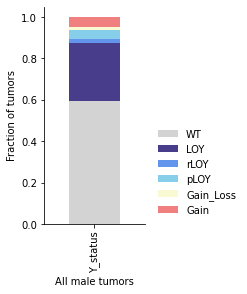

In [40]:
# Figure 1C
# Y-status stacked bar plot for all male cases
df = (male_CNV_calls_filtered['Y_status'].value_counts()/male_CNV_calls_filtered['Y_status'].count())[Y_status_labels]

fig, ax = plt.subplots(1,1, figsize = (1.8,4))
pd.DataFrame(df).transpose().plot.bar(stacked=True, color=Y_status_colors, ax=ax)
ax.set_ylabel('Fraction of tumors')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
ax.legend(bbox_to_anchor=(2, 0), frameon=False,  loc= 'lower right')
ax.set_xlabel("All male tumors")
plt.savefig(fig_dir + 'Y_status_all_male_cases.pdf')

 WT/LOY MWU MannwhitneyuResult(statistic=3685187.0, pvalue=0.0)
 WT/rLOY MWU MannwhitneyuResult(statistic=259708.0, pvalue=5.085491279654839e-34)
 WT/pLOY MWU MannwhitneyuResult(statistic=420770.0, pvalue=7.552140065570432e-37)
 WT/Gain_loss MWU MannwhitneyuResult(statistic=78504.0, pvalue=0.00011814555850369014)
 WT/Gain MWU MannwhitneyuResult(statistic=206821.0, pvalue=1.957952895135539e-16)
WT/LOX MWU MannwhitneyuResult(statistic=1223638.5, pvalue=4.767271778009198e-165)
WT/pLOX MWU MannwhitneyuResult(statistic=929417.5, pvalue=2.1243915657325584e-30)
WT/Gain_Loss MWU MannwhitneyuResult(statistic=1165439.5, pvalue=8.141728041048747e-51)
WT/Gain MWU MannwhitneyuResult(statistic=775582.0, pvalue=0.991163352363791)


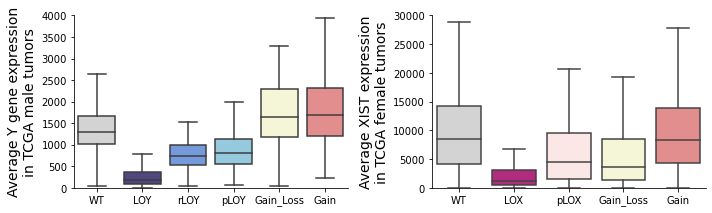

In [41]:
# Figure 1D
# confirm calls with chrY and XIST expression

# Figure 1D
# chrY expression in bona fide male LOY tumors
fig, ax = plt.subplots(1,2, figsize=(10,3))
sns.boxplot(x = 'Y_status', y = 'avgYexp_tumor', data = male_CNV_calls_filtered, fliersize=0, ax=ax[0], order = ['WT', 'LOY', 'rLOY', 'pLOY', 'Gain_Loss', 'Gain'], palette=status_palette)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylabel('Average Y gene expression\nin TCGA male tumors', fontsize=14)
ax[0].set_xlabel('');
ax[0].set_ylim(0,4000)

# Supplementary Figure 3A
# XIST expression in bona fide female LOX tumors
sns.boxplot(x = 'X_status', y = 'XIST', data = female_CNV_calls_filtered, fliersize=0, order = ['WT', 'LOX', 'pLOX', 'Gain_Loss', 'Gain' ], ax= ax[1], palette=status_palette)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_ylabel('Average XIST expression\nin TCGA female tumors', fontsize=14)
ax[1].set_xlabel('');
ax[1].set_ylim(0,30000)
plt.tight_layout()
plt.savefig(fig_dir + 'AvgY_XIST_exp_by_sex_chromosome_status.pdf')

# p-values
# WT/LOY
print(' WT/LOY MWU', mannwhitneyu(male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='WT')].avgYexp_tumor.dropna(), male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='LOY')].avgYexp_tumor.dropna()))

# WT/rLOY
print(' WT/rLOY MWU', mannwhitneyu(male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='WT')].avgYexp_tumor.dropna(), male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='rLOY')].avgYexp_tumor.dropna()))

# WT/pLOY
print(' WT/pLOY MWU', mannwhitneyu(male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='WT')].avgYexp_tumor.dropna(), male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='pLOY')].avgYexp_tumor.dropna()))

# WT/Gain_Loss
print(' WT/Gain_loss MWU', mannwhitneyu(male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='WT')].avgYexp_tumor.dropna(), male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='Gain_Loss')].avgYexp_tumor.dropna()))

# WT/Gain
print(' WT/Gain MWU', mannwhitneyu(male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='WT')].avgYexp_tumor.dropna(), male_CNV_calls_filtered[(male_CNV_calls_filtered.Y_status=='Gain')].avgYexp_tumor.dropna()))


# p-values
# WT/LOX
print('WT/LOX MWU', mannwhitneyu(female_CNV_calls_filtered[(female_CNV_calls_filtered.X_status=='WT')].XIST.dropna(), female_CNV_calls_filtered[(female_CNV_calls_filtered.X_status=='LOX')].XIST.dropna()))

# WT/pLOX
print('WT/pLOX MWU', mannwhitneyu(female_CNV_calls_filtered[(female_CNV_calls_filtered.X_status=='WT')].XIST.dropna(), female_CNV_calls_filtered[(female_CNV_calls_filtered.X_status=='pLOX')].XIST.dropna()))

# WT/Gain_Loss
print('WT/Gain_Loss MWU', mannwhitneyu(female_CNV_calls_filtered[(female_CNV_calls_filtered.X_status=='WT')].XIST.dropna(), female_CNV_calls_filtered[(female_CNV_calls_filtered.X_status=='Gain_Loss')].XIST.dropna()))

# WT/Gain
print('WT/Gain MWU', mannwhitneyu(female_CNV_calls_filtered[(female_CNV_calls_filtered.X_status=='WT')].XIST.dropna(), female_CNV_calls_filtered[(female_CNV_calls_filtered.X_status=='Gain')].XIST.dropna()))


<h3> Comparison of LOY calls with flOY calls </h3>

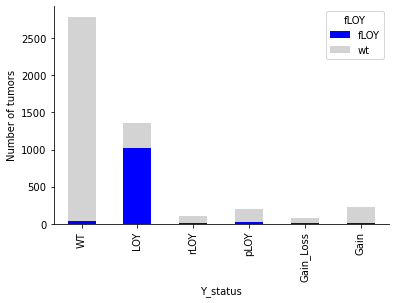

In [42]:
# Supplementary Figure 2A
df =male_CNV_calls_filtered[['Y_status', 'fLOY']].value_counts().unstack().loc[['WT', 'LOY', 'rLOY', 'pLOY', 'Gain_Loss', 'Gain']]
df.plot.bar(stacked=True, color = ['blue', 'lightgrey'])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('Number of tumors')
plt.savefig(fig_dir + 'fLOY_LOY_comparison_by_category.pdf')


<h3> Relationship of discordant LOY/fLOY calls with purity </h3>

In [43]:
# TCGA tumor purity and ploidy estimates obtained from https://gdc.cancer.gov/about-data/publications/pancanatlas
purity_ploidy = pd.read_csv('TCGA_mastercalls.abs_tables_JSedit.fixed.txt', sep='\t', header=0, index_col=0)

# keep only primary tumor sample to avoid errors with multiple patient hits (RNA-seq and DNA were taken from different aliquots anyways)
purity_ploidy =purity_ploidy.loc[[x for x in purity_ploidy.index.values if x.endswith('-01')  ]]
purity_ploidy.index = map(lambda x: x[0:12], purity_ploidy.index.values)
purity_ploidy['type'] = purity_ploidy.apply(lambda x: TCGA_sample_info.loc[x.name].type if x.name in TCGA_sample_info.index else 'NA', axis=1)
purity_ploidy['gender'] = purity_ploidy.apply(lambda x: TCGA_sample_info.loc[x.name].gender if x.name in TCGA_sample_info.index else 'NA', axis=1)
TCGA_sample_info['purity'] = TCGA_sample_info.apply(lambda x: purity_ploidy.loc[x.name].purity if x.name in purity_ploidy.index else np.nan, axis=1)
TCGA_sample_info['ploidy'] = TCGA_sample_info.apply(lambda x: purity_ploidy.loc[x.name].ploidy if x.name in purity_ploidy.index else np.nan, axis=1)
TCGA_sample_info['Genome doublings'] = TCGA_sample_info.apply(lambda x: purity_ploidy.loc[x.name]['Genome doublings'] if x.name in purity_ploidy.index else np.nan, axis=1)

median_purity = purity_ploidy.groupby('type')['purity'].median()
median_purity.loc['LAML'] = np.nan


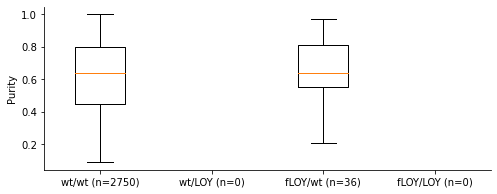

In [44]:
# Supplementary Figure 2B
wt_wt = TCGA_sample_info[(TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.fLOY=='wt') & (TCGA_sample_info.LOY_status=='WT')]
wt_LOY = TCGA_sample_info[(TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.fLOY=='wt') & (TCGA_sample_info.LOY_status=='LOY')]
fLOY_wt = TCGA_sample_info[(TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.fLOY=='fLOY') & (TCGA_sample_info.LOY_status=='WT')]
fLOY_LOY = TCGA_sample_info[(TCGA_sample_info.gender=='MALE') & (TCGA_sample_info.fLOY=='fLOY') & (TCGA_sample_info.LOY_status=='LOY')]
plt.figure(figsize=(8,3)) 
plt.boxplot([wt_wt.purity.dropna(), wt_LOY.purity.dropna(), fLOY_wt.purity.dropna(), fLOY_LOY.purity.dropna()])
plt.ylabel('Purity')
plt.xticks([1,2,3,4], labels=['wt/wt (n=' + str(len(wt_wt)) + ')', 'wt/LOY (n=' + str(len(wt_LOY)) + ')', 'fLOY/wt (n=' + str(len(fLOY_wt)) + ')', 'fLOY/LOY (n=' + str(len(fLOY_LOY)) + ')']);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig(fig_dir + 'fLOY_LOY_comparison_purity.pdf')



<h3> Differential gene expression for WT and LOY and WT and LOX samples, median PAR gene expression reduction </h3>

In [45]:
# differential expression in males with complete LOY/wt

LOY_common_males = [x for x in LOY_cases if x in tumor_exp_unique.columns]
wtY_common_males = [x for x in wtY_cases if x in tumor_exp_unique.columns]

diff_exp = tumor_exp_unique.apply(lambda x: ttest_ind(x[LOY_common_males], x[wtY_common_males], nan_policy='omit').pvalue, axis=1).to_frame()
diff_exp.columns = ['ttest_p']
diff_exp['ttest_p_no_zero'] = diff_exp.apply(lambda x: 1e-16 if x.ttest_p <1e-16 else x.ttest_p, axis=1)
diff_exp['avg_LOY'] = diff_exp.apply(lambda x: np.nanmean(tumor_exp_unique.loc[x.name][LOY_common_males]), axis=1)
diff_exp['avg_wtY'] = diff_exp.apply(lambda x: np.nanmean(tumor_exp_unique.loc[x.name][wtY_common_males]), axis=1)
diff_exp['log2_fold_diff'] = diff_exp.apply(lambda x: np.log2(float(x.avg_LOY)/float(max(x.avg_wtY,0.00001))), axis=1)
diff_exp['qval'] = fdrcorrection(diff_exp.ttest_p_no_zero)[1]

# Make sure to remove inf and nans, otherwise scatterplot will throw mystery session error!
diff_exp.replace([np.inf, -np.inf], np.nan, inplace=True)
diff_exp.dropna(inplace=True)

In [46]:
# differential expression in females with LOX/wt

LOX_common_females = [x for x in LOX_cases if x in tumor_exp_unique.columns]
wtX_common_females = [x for x in wtX_cases if x in tumor_exp_unique.columns]

diff_exp_females = tumor_exp_unique.apply(lambda x: ttest_ind(x[LOX_common_females], x[wtX_common_females], nan_policy='omit').pvalue, axis=1).to_frame()
diff_exp_females.columns = ['ttest_p']
diff_exp_females['ttest_p_no_zero'] = diff_exp_females.apply(lambda x: 1e-16 if x.ttest_p <1e-16 else x.ttest_p, axis=1)
diff_exp_females['avg_LOX'] = diff_exp_females.apply(lambda x: np.nanmean(tumor_exp_unique.loc[x.name][LOX_common_females]), axis=1)
diff_exp_females['avg_wtX'] = diff_exp_females.apply(lambda x: np.nanmean(tumor_exp_unique.loc[x.name][wtX_common_females]), axis=1)
diff_exp_females['log2_fold_diff'] = diff_exp_females.apply(lambda x: np.log2(float(x.avg_LOX)/float(max(x.avg_wtX,0.00001))), axis=1)
diff_exp_females['qval'] = fdrcorrection(diff_exp_females.ttest_p_no_zero)[1]

# Make sure to remove inf and nans, otherwise scatterplot will throw mystery session error!
diff_exp_females.replace([np.inf, -np.inf], np.nan, inplace=True)
diff_exp_females.dropna(inplace=True)




In [47]:
# Expression of PAR genes in samples w/wo LOY
par_exp = tumor_exp_unique.loc[[x for x in par_genes if x in tumor_exp_unique.index]].transpose()

print('Median fold difference LOY/wt for PAR genes:', np.power(2,np.nanmedian(diff_exp.loc[par_exp.columns].log2_fold_diff.dropna())))
print('Median fold difference LOX/wt for PAR genes:', np.power(2,np.nanmedian(diff_exp_females.loc[par_exp.columns].log2_fold_diff.dropna())))

Median fold difference LOY/wt for PAR genes: 0.6818910872353361
Median fold difference LOX/wt for PAR genes: 0.7424572022363141


<h3> Fraction of LOY and LOX by tumor type </h3>

,Gain,Gain_Loss,LOY,WT,pLOY,rLOY,fraction_fLOY,sample_counts
KIRP,0.004785,0.004785,0.799043,0.181818,0.000000,0.009569,0.775701,209
ESCA,0.025641,0.025641,0.570513,0.256410,0.115385,0.006410,0.443038,156
KICH,0.000000,0.000000,0.526316,0.447368,0.026316,0.000000,0.338710,38
PAAD,0.029703,0.000000,0.475248,0.475248,0.009901,0.009901,0.156863,101
STAD,0.024823,0.017730,0.468085,0.429078,0.035461,0.024823,0.364912,282
UVM,0.022222,0.000000,0.466667,0.511111,0.000000,0.000000,0.466667,45
ACC,0.000000,0.032258,0.451613,0.483871,0.032258,0.000000,0.406250,31
CHOL,0.000000,0.000000,0.437500,0.562500,0.000000,0.000000,0.050000,16
KIRC,0.006192,0.000000,0.424149,0.560372,0.000000,0.009288,0.222543,323
LUSC,0.063187,0.038462,0.423077,0.359890,0.087912,0.027473,0.361930,364


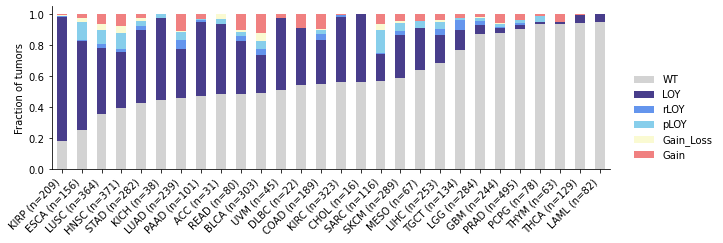

In [48]:
# Calculate the fraction LOY across tumor types in males
tumor_types_male  = (male_CNV_calls_filtered[['Cohort','Y_status']].value_counts()/male_CNV_calls_filtered[['Cohort']].value_counts()).unstack()
tumor_types_male.replace(np.nan, 0, inplace=True)
tumor_types_male.columns.name = None
tumor_types_male.index.name = None
tumor_types_male['fraction_fLOY'] = tumor_types_male.apply(lambda x:TCGA_fLOY_status[(TCGA_fLOY_status.type == x.name) & (TCGA_fLOY_status.gender=='MALE') & (TCGA_fLOY_status.Y_status=='fLOY')].shape[0]/TCGA_fLOY_status[(TCGA_fLOY_status.type == x.name) & (TCGA_fLOY_status.gender=='MALE') & (TCGA_fLOY_status.Y_status!='NaN')].shape[0], axis=1)
tumor_types_male['sample_counts'] = tumor_types_male.apply(lambda x: male_CNV_calls_filtered[['Cohort']].value_counts()[x.name], axis=1)

# remove BRCA, only 11 tumors
tumor_types_male.drop('BRCA', inplace=True)
tumor_types_male.sort_values(by='WT', ascending=True, inplace=True)

df=tumor_types_male[Y_status_labels]

# Figure 2A
fig, ax = plt.subplots(1,1, figsize = (10,3))
df.plot.bar(stacked=True, color = status_palette, ax=ax)
ax.legend(bbox_to_anchor=(1.2, 0), frameon=False,  loc= 'lower right')
ax.set_ylabel("Fraction of tumors")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([x + ' (n=' + str(int(tumor_types_male.loc[x].sample_counts)) + ')' for x in df.index], ha='right', rotation=45)
plt.savefig(fig_dir + 'Y_status_by_type.pdf')

tumor_types_male.sort_values(by='LOY', ascending=False)


In [49]:
tumor_types_male.to_csv('LOY_rate_by_tumor_type.tsv', sep='\t', header=True, index = True)

,Gain,Gain_Loss,LOX,WT,pLOX,sample_counts
KICH,0.074074,0.000000,0.555556,0.370370,0.000000,27
UVM,0.028571,0.000000,0.428571,0.514286,0.028571,35
SKCM,0.105556,0.127778,0.311111,0.311111,0.144444,180
UCS,0.140351,0.210526,0.298246,0.192982,0.157895,57
OV,0.079727,0.380410,0.280182,0.045558,0.214123,439
MESO,0.066667,0.000000,0.266667,0.466667,0.200000,15
KIRP,0.108108,0.054054,0.243243,0.567568,0.027027,74
LUSC,0.092308,0.253846,0.230769,0.238462,0.184615,130
ESCA,0.074074,0.259259,0.222222,0.259259,0.185185,27
STAD,0.152866,0.146497,0.216561,0.356688,0.127389,157


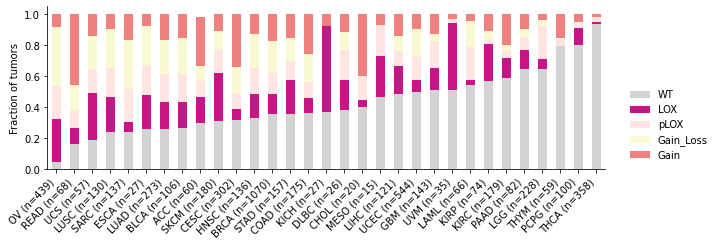

In [50]:
# Supplementary Figure 3B
tumor_types_female = (female_CNV_calls_filtered[['Cohort','X_status']].value_counts()/female_CNV_calls_filtered[['Cohort']].value_counts()).unstack()
tumor_types_female.replace(np.nan, 0, inplace=True)
tumor_types_female.columns.name = None
tumor_types_female.index.name = None
tumor_types_female['sample_counts'] = tumor_types_female.apply(lambda x: female_CNV_calls_filtered[['Cohort']].value_counts()[x.name], axis=1)
tumor_types_female.sort_values(by='WT', inplace=True, ascending = True)


df = tumor_types_female[['WT', 'LOX',  'pLOX', 'Gain_Loss', 'Gain' ]]

fig, ax = plt.subplots(1,1, figsize = (10,3))
df.plot.bar(stacked=True, color = status_palette, ax=ax)
ax.legend(bbox_to_anchor=(1.2, 0), frameon=False,  loc= 'lower right')
ax.set_ylabel("Fraction of tumors")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([x + ' (n=' + str(int(tumor_types_female.loc[x].sample_counts)) + ')' for x in df.index], ha='right', rotation=45)
plt.savefig(fig_dir + 'X_status_by_type.pdf')

tumor_types_female.sort_values(by='LOX', ascending=False)

In [51]:
tumor_types_female.to_csv('LOX_rate_by_tumor_type.tsv', sep='\t', header=True, index = True)

<h3> Comparison of LOY, fLOY and LOX rates by tumor type </h3>

(0.0, 0.85)

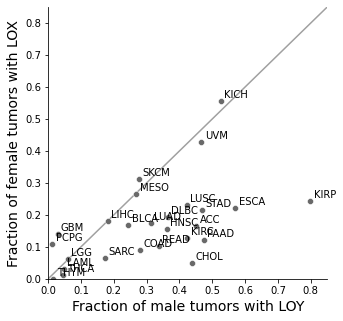

In [52]:
male_female_tumor_types = tumor_types_female.merge(tumor_types_male, how='inner', left_index=True, right_index=True)

# Supplementary Figure 3C
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(x = 'LOY', y = 'LOX', data = male_female_tumor_types, color='dimgrey')
ax.plot([0,1], [0,1], color = 'grey', linestyle='solid', alpha=0.75, zorder=0)
for index, row in male_female_tumor_types.iterrows():
    ax.text(row.LOY+ 0.01, row.LOX+0.01, row.name)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Fraction of female tumors with LOX', fontsize=14)
ax.set_xlabel('Fraction of male tumors with LOY', fontsize=14)
ax.set_ylim(0,0.85)
ax.set_xlim(0,0.85)

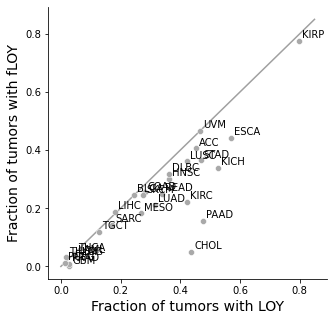

In [53]:
# Supplementary Figure 2E
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot(x = 'LOY', y = 'fraction_fLOY', data = tumor_types_male, color='darkgrey')
for index, row in tumor_types_male.iterrows():
    ax.text(row.LOY+ 0.01, row.fraction_fLOY+0.01, row.name)
ax.plot([0,0.85], [0,0.85], color = 'grey',  linestyle='solid', alpha=0.75, zorder=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Fraction of tumors with fLOY', fontsize=14)
ax.set_xlabel('Fraction of tumors with LOY', fontsize=14)
plt.savefig(fig_dir + 'LOY_fLOY_scatter_tumor_types.pdf')


<h3> LOY  by genome doubling status </h3>

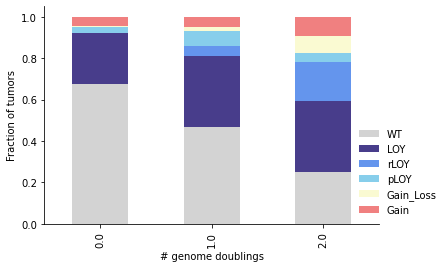

In [54]:
# Figure 2C
colors = ['lightgrey', 'darkslateblue', 'cornflowerblue', 'skyblue', 'lightgoldenrodyellow', 'lightcoral']
colors 
df = (male_CNV_calls_filtered[['Genome_doublings_tcga','Y_status']].value_counts()/male_CNV_calls_filtered[['Genome_doublings_tcga']].value_counts()).unstack()[Y_status_labels]
df.plot.bar(stacked=True, color=colors)
plt.ylabel('Fraction of tumors')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(1.2, 0), frameon=False,  loc= 'lower right')
plt.xlabel('# genome doublings')
plt.savefig(fig_dir + 'Y_status_all_male_cases_by_WGD.pdf')


<h3> Difference in age for LOY and WT patients </h3>

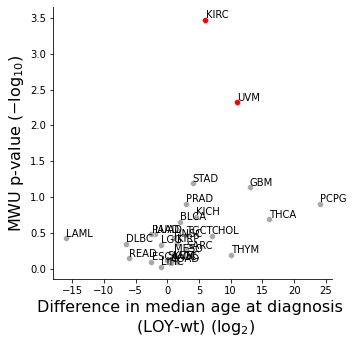

In [82]:
# Supplementary Figure 6A
# Difference in age at diagnosis for WT and LOY patients by tumor type
tumor_types_male[['median_age_LOY', 'median_age_wt', 'diff_age', 'age_p']]=np.nan

for index, row in tumor_types_male.iterrows():    
    m_LOY = np.nanmedian(TCGA_sample_info[(TCGA_sample_info.type==index) & (TCGA_sample_info.LOY_status=='t0LOY')].age_at_initial_pathologic_diagnosis)
    m_wt =  np.nanmedian(TCGA_sample_info[(TCGA_sample_info.type==index) & (TCGA_sample_info.LOY_status=='WT')].age_at_initial_pathologic_diagnosis)
    
    if not (np.isnan(m_LOY) or np.isnan(m_wt)):
        p = mannwhitneyu(TCGA_sample_info[(TCGA_sample_info.type==index) & (TCGA_sample_info.LOY_status=='t0LOY')].age_at_initial_pathologic_diagnosis.dropna(), TCGA_sample_info[(TCGA_sample_info.type==index) & (TCGA_sample_info.LOY_status=='WT')].age_at_initial_pathologic_diagnosis.dropna())[1]
    else:
        p = np.nan

    tumor_types_male.at[index,'median_age_LOY'] = m_LOY
    tumor_types_male.at[index,'median_age_wt'] = m_wt
    tumor_types_male.at[index,'diff_age'] = m_LOY-m_wt
    tumor_types_male.at[index,'age_p'] = p

tumor_types_male['age_q'] = fdrcorrection(tumor_types_male.age_p)[1]

# Supplementary Figure 
fig, ax = plt.subplots(1,1, figsize = (5,5))
sns.scatterplot(x = tumor_types_male.diff_age, y = -np.log10(tumor_types_male.age_p),  color='darkgrey')
sns.scatterplot(x = tumor_types_male[tumor_types_male.age_q<0.1].diff_age, y = -np.log10(tumor_types_male[tumor_types_male.age_q<0.1].age_p), color='red')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for index, row in tumor_types_male.iterrows():
    ax.text(row.diff_age+0.02, -np.log10(row.age_p)+0.02, row.name)
ax.set_xlabel('Difference in median age at diagnosis \n (LOY-wt) ($\mathregular{log_2}$)', fontsize=16)                
ax.set_ylabel('MWU p-value ($\mathregular{-log_{10}}$)',fontsize=16)      ;

plt.savefig(fig_dir + 'LOY_WT_age_diff_by_tumor_type.pdf')

<h3> Association with genome instability </h3>

In [83]:
# fraction of genome altered and aneuploidy scores (Taylor et al, https://www.cell.com/cancer-cell/pdfExtended/S1535-6108(18)30111-9, Table S2)
genome_instability_values = pd.read_excel('1-s2.0-S1535610818301119-mmc2.xlsx', sheet_name=0,header=0,skiprows=1, index_col=0)
genome_instability_values.index = [x[0:12] for x in genome_instability_values.index]
genome_instability_values['tumor_type'] = genome_instability_values.apply(lambda x: TCGA_sample_info.loc[x.name]['type'] if x.name in TCGA_sample_info.index else 'NA', axis=1)
genome_instability_values['LOY_status'] = genome_instability_values.apply(lambda x: 'NA' if not x.name in male_CNV_calls_filtered.index else male_CNV_calls_filtered.loc[x.name].Y_status, axis=1)
genome_instability_values_males = genome_instability_values.loc[[x for x in males if x in genome_instability_values.index]]



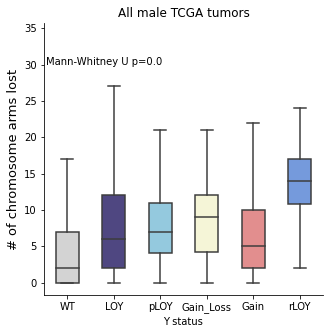

In [84]:
# Figure 2D
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.boxplot(x = 'LOY_status', y = 'AS_del', data=genome_instability_values_males[genome_instability_values_males.LOY_status!='NA'], orient='v', fliersize=0, palette=status_palette, width=0.5)
ax.set_xlabel('Y status')
ax.set_ylabel('# of chromosome arms lost', fontsize=13)
ax.set_title('All male TCGA tumors') 
ax.text(x=-0.45, y=30, s='Mann-Whitney U p=' + str(round(mannwhitneyu(genome_instability_values_males[genome_instability_values_males.LOY_status=='LOY']['AS_del'].dropna(), genome_instability_values_males[genome_instability_values_males.LOY_status=='WT']['AS_del'].dropna()).pvalue,9)))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_dir + 'LOY_arm_del_boxplot.pdf')

Text(0, 13, "Pearson's r =0.33; P=0.0833")

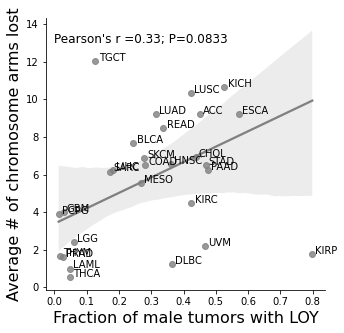

In [85]:
# Figure 2E
tumor_types_male['avg_AS'] = tumor_types_male.apply(lambda x: np.nanmean(genome_instability_values_males[genome_instability_values_males['tumor_type']==x.name]['AS_del']), axis=1)
tumor_types_male.replace(np.nan, 0, inplace=True)

AS_r, AS_p = pearsonr(tumor_types_male.LOY,tumor_types_male.avg_AS)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(x = 'LOY', y = 'avg_AS' , data = tumor_types_male, ax=ax, color = 'grey', robust=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for index, row in tumor_types_male.iterrows():
    ax.text(row.LOY+0.01, row.avg_AS+0.01, row.name)
ax.set_xlabel('Fraction of male tumors with LOY', fontsize=16)                
ax.set_ylabel('Average # of chromosome arms lost',fontsize=16)      
ax.text(0,13, 'Pearson\'s r =' + str(round(AS_r, 2)) + '; P=' + str(round(AS_p, 4)), fontsize = 12)
plt.savefig(fig_dir + 'LOY_AS_del_by_tumor_type.pdf')


<h3 Associations with TP53 mutations</h3>

Fraction WT Y + TP53mut 0.2566934404283802
Fraction LOY + TP53mut 0.47697841726618706


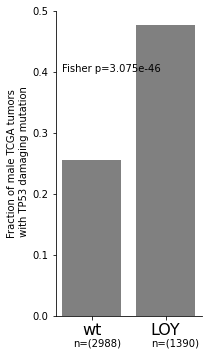

In [86]:
# Significance of overlap with TP53 mutations
# TP53 mutations obtained from TCGA Pancancer MC3 maf

mc3_tp53 = pd.read_csv('mc3.TP53.maf', sep='\t', header=0, index_col=0)
mc3_tp53_pass = mc3_tp53[mc3_tp53['FILTER']=='PASS']
mc3_tp53_pass['patient'] = mc3_tp53_pass.apply(lambda x: x.Tumor_Sample_Barcode[0:12], axis=1)
damaging_events = ['Frame_Shift_Del', 'Nonsense_Mutation', 'Missense_Mutation' ,'Frame_Shift_Ins' ,'Splice_Site' ,'Translation_Start_Site',  'In_Frame_Del']

tp53_damaging = mc3_tp53_pass[mc3_tp53_pass.Variant_Classification.isin(damaging_events)]

LOY_tp53mut = len([x for x in TCGA_sample_info[(TCGA_sample_info.LOY_status=='t0LOY') & (TCGA_sample_info.gender=='MALE')].index if x in list(tp53_damaging.patient)])
LOY_tp53wt = len([x for x in TCGA_sample_info[(TCGA_sample_info.LOY_status=='t0LOY') & (TCGA_sample_info.gender=='MALE')].index if x not in list(tp53_damaging.patient)])
wtY_tp53mut = len([x for x in TCGA_sample_info[(TCGA_sample_info.LOY_status=='WT') & (TCGA_sample_info.gender=='MALE')].index if x in list(tp53_damaging.patient)])
wtY_tp53wt = len([x for x in TCGA_sample_info[(TCGA_sample_info.LOY_status=='WT') & (TCGA_sample_info.gender=='MALE')].index if (x not in list(tp53_damaging.patient))])


tp53_fisher = fisher_exact([[LOY_tp53mut, LOY_tp53wt],[wtY_tp53mut, wtY_tp53wt]])


# Figure 3A
# barplot with relative numbers/fraction of total
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
plt.bar([0,1],[ float(wtY_tp53mut)/float(wtY_tp53mut+ wtY_tp53wt), float(LOY_tp53mut)/float(LOY_tp53mut+LOY_tp53wt)], align='center', color='grey', tick_label=['wt', 'LOY'])
ax.set_ylabel('Fraction of male TCGA tumors\n with TP53 damaging mutation') 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(0.8,-.05 ,'n=(' + str(LOY_tp53mut+ LOY_tp53wt) +  ')')
ax.text(-0.25,-.05 ,'n=(' + str(wtY_tp53mut+ wtY_tp53wt) +  ')')
ax.text(x=-0.4, y=0.4, s="Fisher p=" + '{:0.3e}'.format(tp53_fisher[1]))
ax.set_xticklabels(['wt', 'LOY'], fontsize=16);
plt.tight_layout()
plt.savefig(fig_dir + '/TP53_mut_WEX.pdf')


print('Fraction WT Y + TP53mut',  float(wtY_tp53mut)/float(wtY_tp53mut+ wtY_tp53wt))
print('Fraction LOY + TP53mut',  float(LOY_tp53mut)/float(LOY_tp53mut+LOY_tp53wt))


<h3> Analysis of cancer cell fractions for LOY and TP53 </h3>

In [ ]:
# TP53 mutations from Pancancer ABSOLUTE MAF:  TCGA_consolidated.abs_mafs_truncated.fixed.txt.gz, damaging mutations only
TP53_CCFs = pd.read_csv('TP53_mut.absolute.maf', sep='\t', header=0)
TP53_CCFs['type'] = TP53_CCFs.apply(lambda x: TCGA_sample_info.loc[x.case_id].type if x.case_id in TCGA_sample_info.index else 'NA', axis=1)


In [ ]:
# CCFs for CNVs calculated by FACETs
CNV_CCF = pd.read_csv('table.arm.amp_del.all_male.cn_state.filtered.ratio_0_5_amp_del.tsv', sep='\t', header=0)
Yp_CCF = CNV_CCF[(CNV_CCF.arm=='Yp') & (CNV_CCF.cn_state=='del')]
Yp_CCF_LOY = Yp_CCF[Yp_CCF.Y_status=='t0LOY']

In [ ]:
# Concatenate TP53 and LOY CCFs in one dataframe
df = Yp_CCF_LOY[['cf.em', 'Cohort']]
df['mut'] = 'Yp'
df.columns = [ 'CCF','type', 'mut']

df2 = TP53_CCFs[['ccf_hat', 'type']]
df2['mut'] = 'TP53'
df2.columns = [ 'CCF','type', 'mut']

df3 = pd.concat([df, df2], ignore_index=True)


# Remove cohorts with fewer than 10 LOY samples
cohorts_to_remove = Yp_CCF_LOY.Cohort.value_counts()[Yp_CCF_LOY.Cohort.value_counts()<10].index
df3_small_cohorts_removed = df3[~(df3.type.isin(cohorts_to_remove.to_list()))]

# Calculate median LOY CCF per tumor type for ordering
median_LOY_ccfs = df3_small_cohorts_removed[df3_small_cohorts_removed.mut=='Yp'].groupby(['type'])['CCF'].median().sort_values(ascending = False)

# Figure 3D
fig, ax = plt.subplots(1,1, figsize = (17,3))
sns.violinplot(x = 'type', y = 'CCF',   inner='box', hue = 'mut', data = df3_small_cohorts_removed, split= False, scale = 'width', scale_hue = False, width = 0.5, palette = ['lightblue', 'lightgreen'], order = median_LOY_ccfs.index[::-1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Yp loss CCF', fontsize=14);
ax.set_xlabel('')
ax.set_ylim(0,1)
plt.savefig(fig_dir + 'Yp_CCF_by_tumor_type.pdf')
